In [1]:
import os
from robustlink._init_plots import *
from robustlink.analysis import CorrRes

# import data
- enhancer-gene pairs (tsv): `./demo_data/enhancer_gene_pairs_1mbp.tsv` 
- correlation results (from the pipeline): 
    - mCG-RNA: `./demo_res/link_rna_mc_ka30_knn30_s0_corr_spearmanr_cluster_r10.tsv`
    - ATAC-RNA: `./demo_res/link_rna_atac_ka30_knn30_s0_corr_spearmanr_cluster_r10.tsv`
    

In [2]:
# pair list
f = './demodata/enhancer_gene_pairs_1mbp.tsv' 
to_evals = pd.read_csv(f, sep='\t', index_col=False)
to_evals = to_evals.astype({'dist': np.int, 'enh': np.int, 'is_in_genebody': np.bool_})
to_evals

/var/folders/5t/5ql_465s2w7g1s3t2c4ttz7c0000gp/T/ipykernel_8471/3163202026.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  to_evals = to_evals.astype({'dist': np.int, 'enh': np.int, 'is_in_genebody': np.bool_})


,gene,enh,dist,is_in_genebody
0,ENSMUSG00000000001,147520,995118,False
1,ENSMUSG00000000001,147522,985740,False
2,ENSMUSG00000000001,147523,983725,False
3,ENSMUSG00000000001,147527,970444,False
4,ENSMUSG00000000001,147528,969372,False
...,...,...,...,...
2589989,ENSMUSG00000115338,70259,45420,False
2589990,ENSMUSG00000115338,70260,86339,False
2589991,ENSMUSG00000115338,70264,242242,False
2589992,ENSMUSG00000115338,70265,294607,False


In [3]:
fname1 = './demo_res/link_rna_mc_ka30_knn30_s0_corr_spearmanr_cluster_r10.tsv'
res_corrs = pd.read_csv(fname1, sep='\t', index_col=0)
res_corrs

,gene,enh,dist,is_in_genebody,corr,corr_shuff,corr_shuff_cells
0,ENSMUSG00000000001,147520,995118,False,-0.034817,-0.029397,-0.005731
1,ENSMUSG00000000001,147522,985740,False,0.089167,-0.309708,-0.035557
2,ENSMUSG00000000001,147523,983725,False,0.176674,-0.021505,0.098711
3,ENSMUSG00000000001,147527,970444,False,-0.404724,0.197334,0.225827
4,ENSMUSG00000000001,147528,969372,False,-0.398445,0.226124,-0.013787
...,...,...,...,...,...,...,...
2589989,ENSMUSG00000115338,70259,45420,False,0.067856,0.264006,0.001492
2589990,ENSMUSG00000115338,70260,86339,False,0.124063,-0.189219,0.068229
2589991,ENSMUSG00000115338,70264,242242,False,0.029446,-0.165998,0.253137
2589992,ENSMUSG00000115338,70265,294607,False,-0.066767,0.019978,0.085458


In [4]:
fname2 = './demo_res/link_rna_atac_ka30_knn30_s0_corr_spearmanr_cluster_r10.tsv'
res2_corrs = pd.read_csv(fname2, sep='\t', index_col=0)
res2_corrs

,gene,enh,dist,is_in_genebody,corr,corr_shuff,corr_shuff_cells
0,ENSMUSG00000000001,147520,995118,False,0.012033,-0.060774,-0.104094
1,ENSMUSG00000000001,147522,985740,False,-0.126822,0.194577,0.035652
2,ENSMUSG00000000001,147523,983725,False,0.043974,0.364802,-0.141169
3,ENSMUSG00000000001,147527,970444,False,-0.008510,-0.250088,-0.158552
4,ENSMUSG00000000001,147528,969372,False,0.135815,-0.210577,-0.062071
...,...,...,...,...,...,...,...
2589989,ENSMUSG00000115338,70259,45420,False,0.260274,0.008315,0.207514
2589990,ENSMUSG00000115338,70260,86339,False,0.014482,-0.138552,-0.006743
2589991,ENSMUSG00000115338,70264,242242,False,-0.317392,-0.041457,-0.086332
2589992,ENSMUSG00000115338,70265,294607,False,-0.197190,-0.029331,-0.065512


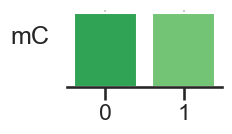

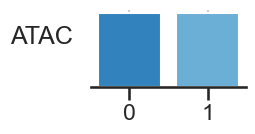

In [5]:
# color palette
cm = plt.cm.tab20c.colors
colors_mc   = [cm[8], cm[9]]
colors_atac = [cm[0], cm[1]]

for color_track, label in zip([colors_mc, colors_atac], ['mC','ATAC']):
    fig, ax = plt.subplots(figsize=(2,1))
    ax.bar(np.arange(2), 1, color=color_track)
    ax.set_xticks(np.arange(2))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

In [6]:
# specify output
output_linked_table_mc   = './demo_res/linked_table_mc.tsv'
output_linked_table_atac = './demo_res/linked_table_atac.tsv'

outdir = os.path.dirname(output_linked_table_mc)
if not os.path.isdir(outdir):
    os.mkdir(outdir)

# Statistical analysis

In [7]:
# set up the `CorrRes` object which we will use to analyze the results
corr_res_mc   = CorrRes(res_corrs, False, label="mCG-RNA", 
                        color=colors_mc[0], lightcolor=colors_mc[1])
corr_res_atac = CorrRes(res2_corrs, True, label="ATAC-RNA",
                        color=colors_atac[0], lightcolor=colors_atac[1])

# Statistical evaluations: testing which pairs are significant
corr_res_mc  .test_significance(output_linked=output_linked_table_mc,   fdr=0.2)
corr_res_atac.test_significance(output_linked=output_linked_table_atac, fdr=0.2)

# statistical evaluation of distance dependence
# estimate the number of links as a function of genomic distances
corr_res_mc  .estimate_dist_dependence()
corr_res_atac.estimate_dist_dependence()

saved to ./demo_res/linked_table_mc.tsv
saved to ./demo_res/linked_table_atac.tsv


# Visualization

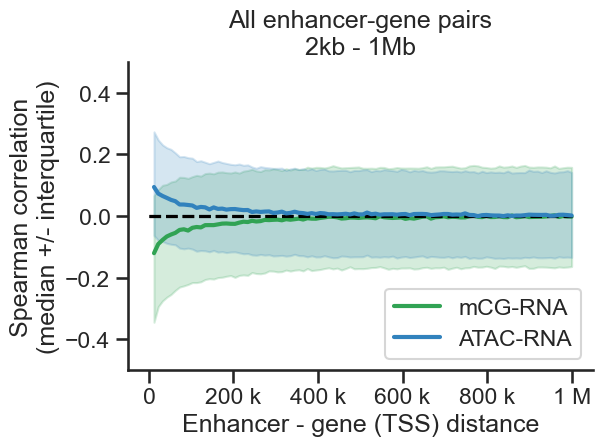

In [8]:
# dist vs corr
fig, ax = plt.subplots(figsize=(6,4))
corr_res_mc  .plot_corr_vs_dist(ax)
corr_res_atac.plot_corr_vs_dist(ax)
plt.show()

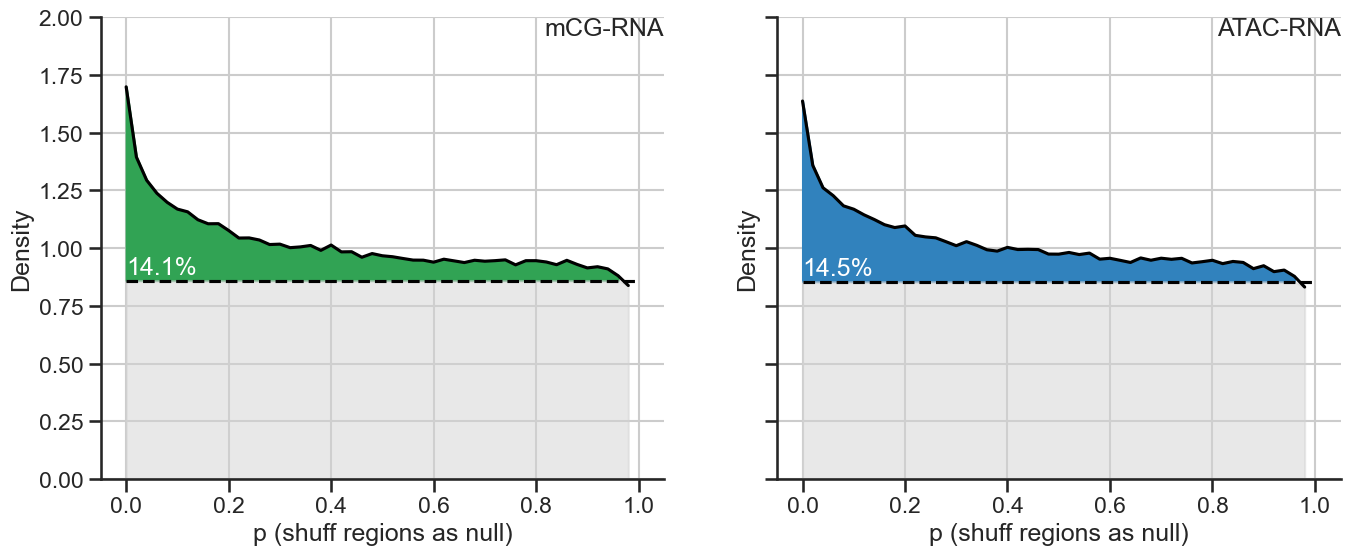

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8*2,6), sharex=True, sharey=True)
corr_res_mc  .plot_pval(ax=axs[0])
corr_res_atac.plot_pval(ax=axs[1])
plt.show()

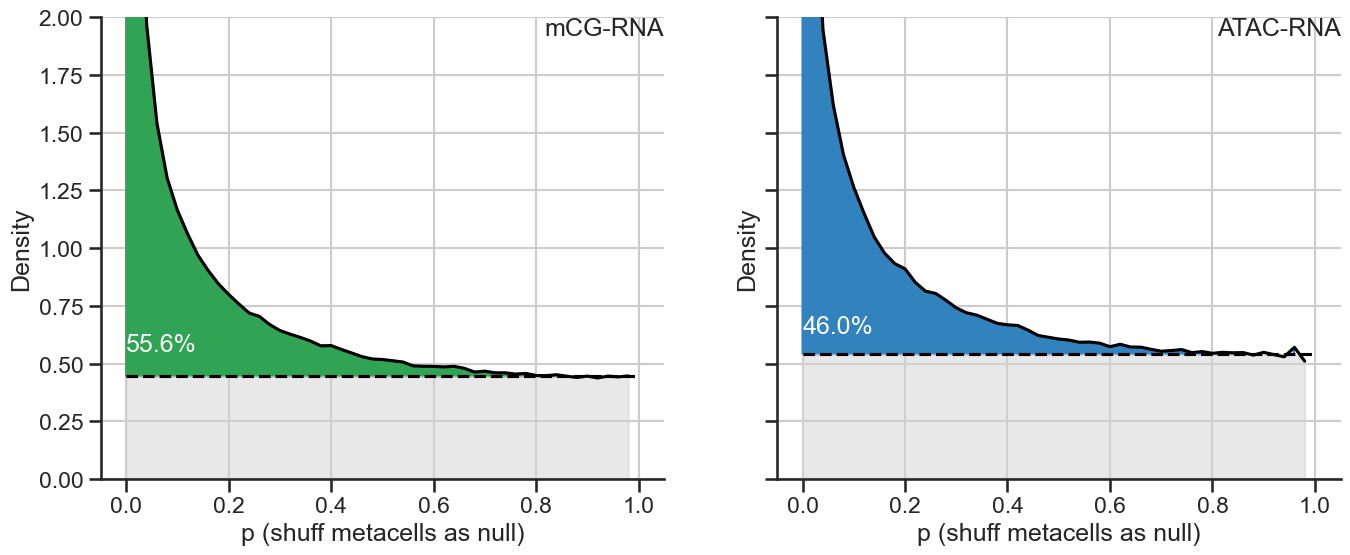

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8*2,6), sharex=True, sharey=True)
corr_res_mc  .plot_pval(ax=axs[0], pval_type='correlated')
corr_res_atac.plot_pval(ax=axs[1], pval_type='correlated')
plt.show()

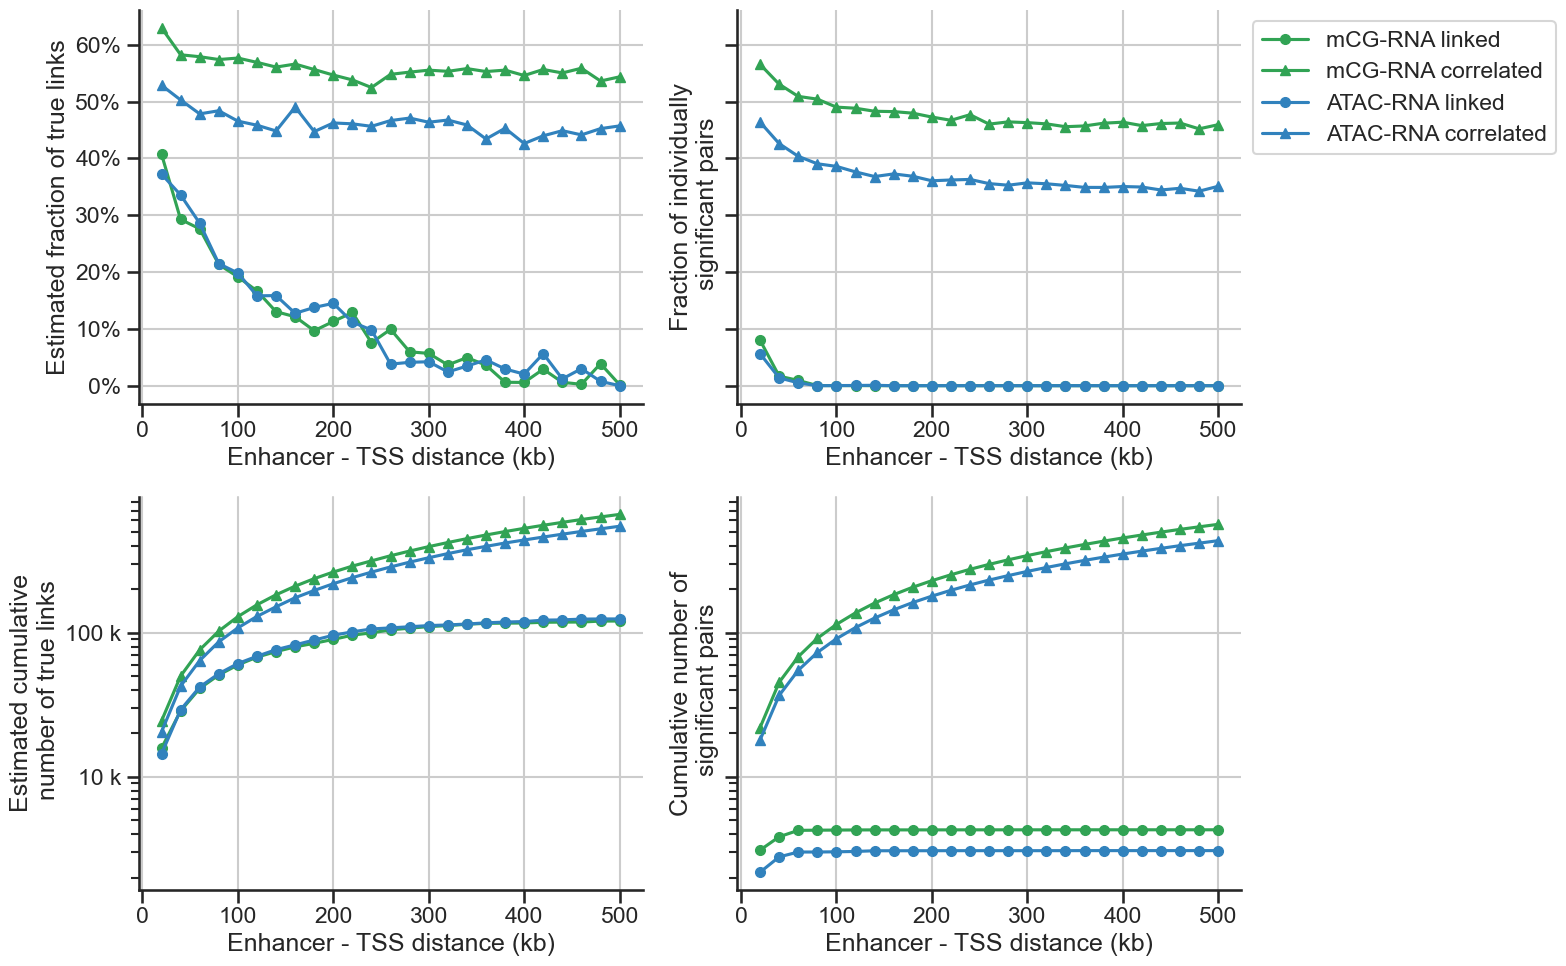

In [11]:
cols = [
    'frac_tp', 
    'sig_frac_tp', 
    'num_pos',
    'sig_num_pos',
]

fig, axs = plt.subplots(2, 2, figsize=(8*2,5*2), sharex=False, sharey='row')
for ax, col in zip(axs.flat, cols): 
    corr_res_mc  .plot_dist_dep(col, 'linked',     ax=ax)
    corr_res_mc  .plot_dist_dep(col, 'correlated', ax=ax)
    corr_res_atac.plot_dist_dep(col, 'linked',     ax=ax)
    corr_res_atac.plot_dist_dep(col, 'correlated', ax=ax)
axs[0,1].legend(bbox_to_anchor=(1,1))
fig.tight_layout()
plt.show()

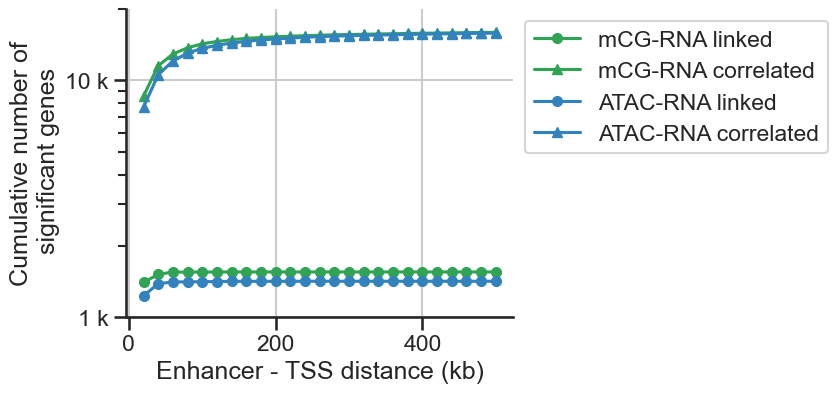

In [12]:
col = 'cum_sig_genes'
fig, ax = plt.subplots(figsize=(5,4))
corr_res_mc  .plot_dist_dep(col, 'linked',     ax=ax)
corr_res_mc  .plot_dist_dep(col, 'correlated', ax=ax)
corr_res_atac.plot_dist_dep(col, 'linked',     ax=ax)
corr_res_atac.plot_dist_dep(col, 'correlated', ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylim(ymin=1e3, ymax=2e4)
plt.show()

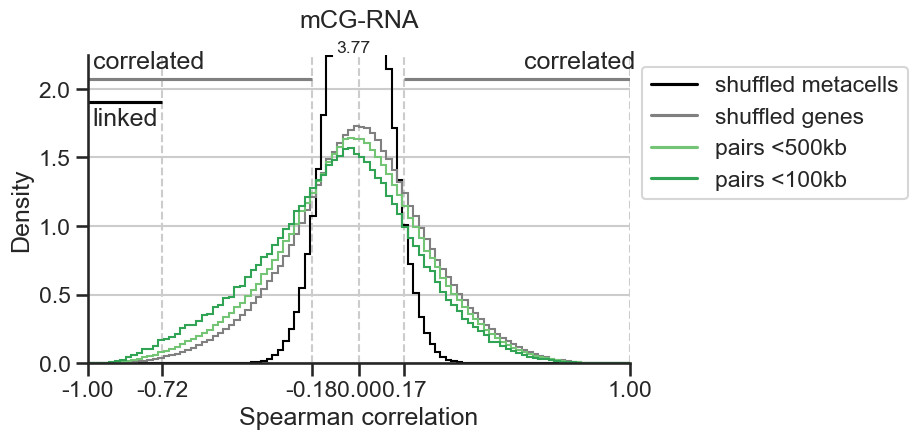

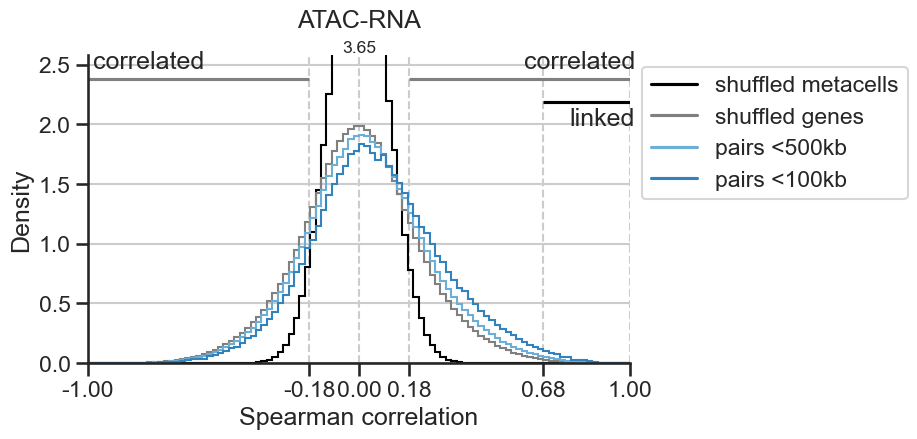

In [13]:
corr_res_mc  .plot_corr_distribution()
corr_res_atac.plot_corr_distribution()

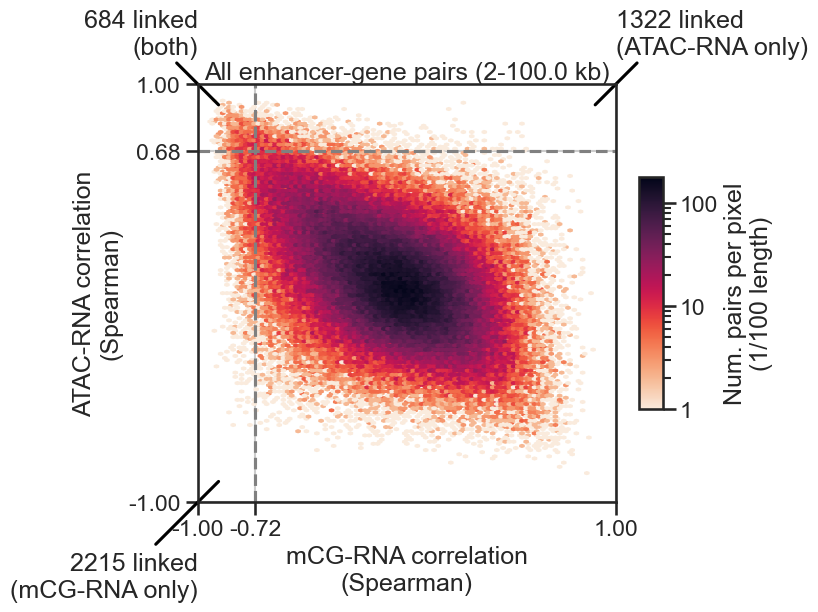

In [14]:
corr_res_mc.plot_corr_bimodal(corr_res_atac, dist_th=1e5)